In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset, Dataset, Subset, random_split, DataLoader, TensorDataset
import os
from PIL import Image
from torchvision.models import resnet50
import torch.optim as optim
import torch.nn as nn
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import zipfile
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
with zipfile.ZipFile('/content/200.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
data_root_40 = '/content/200'  

In [ ]:
class Normalize(object):
    def __call__(self, img):
        mean = img.mean(dim=(1, 2), keepdim=True)
        std = img.std(dim=(1, 2), keepdim=True)
        return (img - mean) / std

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((350, 230)),
    transforms.RandomCrop((224, 224)),
    Normalize()
])

In [ ]:
dataset_40 = ImageFolder(root=data_root_40, transform=data_transform)
print(dataset_40.classes)

['benign', 'malignant']


Image Path: /content/200/malignant/SOB_M_DC-14-20636-200-015.png
Label: 1
Class Name: malignant
(700, 460)


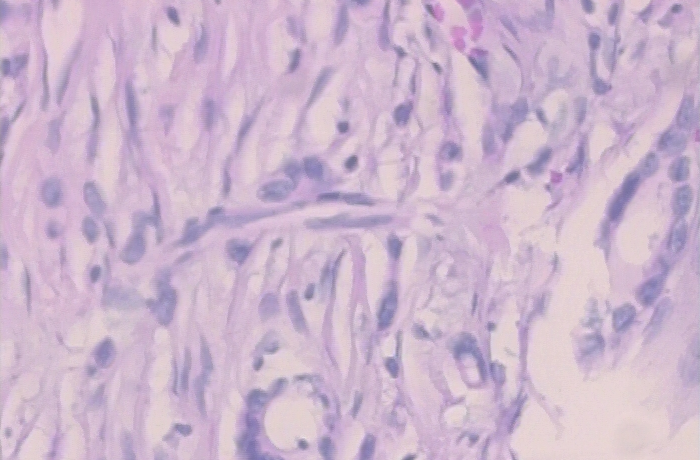

In [ ]:
image_path, label = dataset_40.imgs[1200]
image = Image.open(image_path)
class_name = dataset_40.classes[label]

print("Image Path:", image_path)
print("Label:", label)
print("Class Name:", class_name)
print(image.size)

image.show()

In [ ]:
train_size_40 = int(0.8 * len(dataset_40))
test_size_40 = len(dataset_40) - train_size_40
train_dataset_40, test_dataset_40 = random_split(dataset_40, [train_size_40, test_size_40])
print(type(train_dataset_40))
batch_size = 64

train_loader_40 = DataLoader(train_dataset_40, batch_size=batch_size, shuffle=True)
test_loader_40 = DataLoader(test_dataset_40, batch_size=batch_size)

<class 'torch.utils.data.dataset.Subset'>


**Augmentation**

In [ ]:
alpha = 0.4
num_epochs = 20

In [ ]:
def standard(img, K = 4):
    # Apply random shift
    k1 = random.randint(-K, K)
    k2 = random.randint(-K, K)
    
    padded_img = F.pad(img, (K, K, K, K))
    height, width = padded_img.size(2), padded_img.size(3)

    cx = width // 2 - k2 
    cy = height // 2 + k1

    left = cx - 112 
    top = cy - 112

    cropped_img = padded_img[:, :, top:top+224, left:left+224]
    
    if random.random() < 0.5:
        cropped_img = torchvision.transforms.RandomHorizontalFlip(1)(cropped_img)

    for i in range(len(cropped_img)):
      img_ = cropped_img[i]
      if random.random() < 0.5:
        img_ = torchvision.transforms.RandomHorizontalFlip(1)(img_)
        cropped_img[i] = img_
    return cropped_img

In [ ]:
def cutout(img, k=16):
    height, width = img.size(2), img.size(3)
    mask = torch.ones((height, width), dtype=torch.uint8)
    cx = random.randint(0, width)
    cy = random.randint(0, height)
    
    left = max(0, cx - k // 2)
    right = min(width, cx + k // 2)
    top = max(0, cy - k // 2)
    bottom = min(height, cy + k // 2)
    for i in range(len(img)):
      img_ = img[i]
      if random.random() < 0.5:
        img_[:, top:bottom, left:right] = 0
        img[i] = img_
    return img

In [ ]:
def mixup(x1, y1, x2, y2, alpha):
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y, lam

**Transfer Learning with pretrained resnet50**

In [ ]:
model = resnet50(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
in_features = model.fc.in_features
num_classes = 2 
model.fc = nn.Linear(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:

model.to(device)
train_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
  # Training phase
  model.train()
  total_correct = 0
  total_samples = 0
  running_loss = 0
  for images, labels in train_loader_40:
    images = images.to(device)
    images = standard(images)
    labels = labels.to(device)
    indices = torch.randperm(images.size(0))
    mixed_images, mixed_labels, lam = mixup(images, labels, images[indices], labels[indices], alpha)
    optimizer.zero_grad()
    outputs = model(mixed_images)
    loss = lam * criterion(outputs, labels) + (1-lam) * criterion(outputs, labels[indices])
    _, predicted = torch.max(outputs, 1)
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)
    loss.backward()
    running_loss += loss.item()
    optimizer.step()
  epoch_train_loss = running_loss / len(train_loader_40)
  train_loss_list.append(epoch_train_loss)
  train_accuracy = total_correct / total_samples
  train_acc_list.append(train_accuracy)
  model.eval()
  with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for images, labels in test_loader_40:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    test_acc_list.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train accuracy: {train_accuracy: .4f} | Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/20], Train accuracy:  0.6124 | Test Accuracy: 0.6973
Epoch [2/20], Train accuracy:  0.6435 | Test Accuracy: 0.7742
Epoch [3/20], Train accuracy:  0.6739 | Test Accuracy: 0.8164
Epoch [4/20], Train accuracy:  0.7106 | Test Accuracy: 0.8238
Epoch [5/20], Train accuracy:  0.6789 | Test Accuracy: 0.8040
Epoch [6/20], Train accuracy:  0.7025 | Test Accuracy: 0.8164
Epoch [7/20], Train accuracy:  0.6839 | Test Accuracy: 0.8337
Epoch [8/20], Train accuracy:  0.7335 | Test Accuracy: 0.7742
Epoch [9/20], Train accuracy:  0.7516 | Test Accuracy: 0.8362
Epoch [10/20], Train accuracy:  0.7720 | Test Accuracy: 0.8734
Epoch [11/20], Train accuracy:  0.6870 | Test Accuracy: 0.8412
Epoch [12/20], Train accuracy:  0.7056 | Test Accuracy: 0.8561
Epoch [13/20], Train accuracy:  0.6969 | Test Accuracy: 0.8337
Epoch [14/20], Train accuracy:  0.7075 | Test Accuracy: 0.8213
Epoch [15/20], Train accuracy:  0.6994 | Test Accuracy: 0.8809
Epoch [16/20], Train accuracy:  0.6981 | Test Accuracy: 0.7022
E

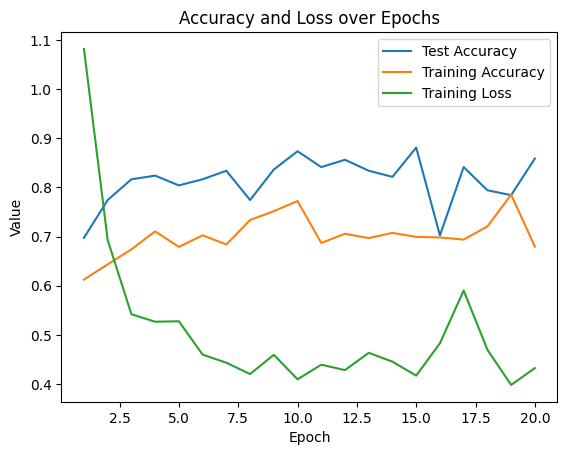

In [ ]:
plt.plot(range(1, num_epochs + 1), test_acc_list, label='Test Accuracy')
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

**Manual Training of resnet50**

In [ ]:
train_size_40 = int(0.8 * len(dataset_40))
test_size_40 = len(dataset_40) - train_size_40
train_dataset_40, test_dataset_40 = random_split(dataset_40, [train_size_40, test_size_40])
print(type(train_dataset_40))
batch_size = 64

train_loader_40 = DataLoader(train_dataset_40, batch_size=batch_size, shuffle=True)
test_loader_40 = DataLoader(test_dataset_40, batch_size=batch_size)

<class 'torch.utils.data.dataset.Subset'>


In [ ]:
model = resnet50(pretrained=True)
in_features = model.fc.in_features
num_classes = 2 
model.fc = nn.Linear(in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.to(device)
train_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
  # Training phase
  model.train()
  i = 0
  total_correct = 0
  total_samples = 0
  running_loss = 0
  for images, labels in train_loader_40:
    images = images.to(device)
    images = standard(images)
    labels = labels.to(device)
    indices = torch.randperm(images.size(0))
    mixed_images, mixed_labels, lam = mixup(images, labels, images[indices], labels[indices], alpha)
    optimizer.zero_grad()
    outputs = model(mixed_images)
    loss = lam * criterion(outputs, labels) + (1-lam) * criterion(outputs, labels[indices])
    _, predicted = torch.max(outputs, 1)
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  epoch_train_loss = running_loss / len(train_loader_40)
  train_loss_list.append(epoch_train_loss)
  train_accuracy = total_correct / total_samples
  train_acc_list.append(train_accuracy)
  model.eval()
  with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for images, labels in test_loader_40:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    test_acc_list.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train accuracy: {train_accuracy: .4f} | Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/20], Train accuracy:  0.6770 | Test Accuracy: 0.6898
Epoch [2/20], Train accuracy:  0.6894 | Test Accuracy: 0.5037
Epoch [3/20], Train accuracy:  0.6913 | Test Accuracy: 0.6873
Epoch [4/20], Train accuracy:  0.6913 | Test Accuracy: 0.6873
Epoch [5/20], Train accuracy:  0.6913 | Test Accuracy: 0.6873
Epoch [6/20], Train accuracy:  0.6969 | Test Accuracy: 0.6923
Epoch [7/20], Train accuracy:  0.6702 | Test Accuracy: 0.7097
Epoch [8/20], Train accuracy:  0.6584 | Test Accuracy: 0.6849
Epoch [9/20], Train accuracy:  0.6764 | Test Accuracy: 0.7667
Epoch [10/20], Train accuracy:  0.6733 | Test Accuracy: 0.7022
Epoch [11/20], Train accuracy:  0.6820 | Test Accuracy: 0.7395
Epoch [12/20], Train accuracy:  0.6814 | Test Accuracy: 0.6873
Epoch [13/20], Train accuracy:  0.6876 | Test Accuracy: 0.7816
Epoch [14/20], Train accuracy:  0.6876 | Test Accuracy: 0.7370
Epoch [15/20], Train accuracy:  0.7410 | Test Accuracy: 0.6898
Epoch [16/20], Train accuracy:  0.7366 | Test Accuracy: 0.7295
E

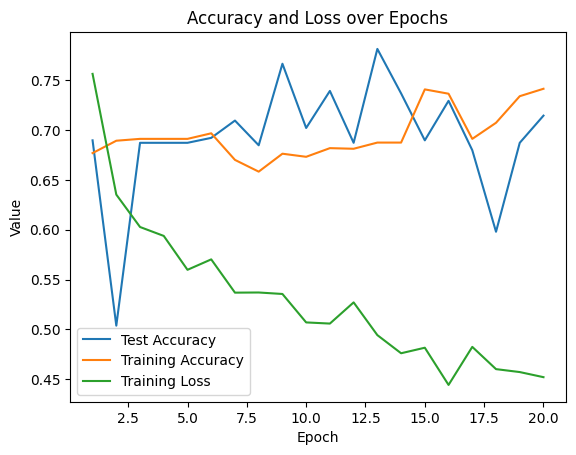

In [ ]:
plt.plot(range(1, num_epochs + 1), test_acc_list, label='Test Accuracy')
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

**Self-supervised learning depending on only 20% labeled data of the training dataset**

In [ ]:
labeled_dataset_size = len(train_dataset_40)
initial_split_ratio = 0.2
initial_split_size = int(initial_split_ratio * labeled_dataset_size)
remaining_split_size = labeled_dataset_size - initial_split_size
dataset_initial_40 = Subset(train_dataset_40, range(initial_split_size)).dataset
dataset_remaining_40 = Subset(train_dataset_40, range(initial_split_size, labeled_dataset_size)).dataset

In [ ]:
print(type(dataset_initial_40))
print(type(dataset_remaining_40))

<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


In [ ]:
model = resnet50(pretrained=True)
in_features = model.fc.in_features
num_classes = 2 
model.fc = nn.Linear(in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 12
batch_size = 16
ss_train_loader_40 = DataLoader(dataset_initial_40, batch_size=batch_size, shuffle=True)

In [ ]:
len(ss_train_loader_40)

101

In [ ]:
model.to(device)
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    model.train()
    for images, labels in ss_train_loader_40:
      images = images.to(device)
      images = standard(images)
      labels = labels.to(device)
      indices = torch.randperm(images.size(0))
      mixed_images, mixed_labels, lam = mixup(images, labels, images[indices], labels[indices], alpha)
      optimizer.zero_grad()
      outputs = model(mixed_images)
      loss = lam * criterion(outputs, labels) + (1-lam) * criterion(outputs, labels[indices])
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)
    train_accuracy = total_correct / total_samples

    print(train_accuracy)

0.6888198757763975
0.691304347826087
0.7130434782608696
0.7130434782608696
0.7422360248447205
0.7161490683229814
0.7360248447204969
0.731055900621118
0.760248447204969
0.7571428571428571
0.7509316770186335
0.7559006211180124


In [ ]:
confidence_threshold = 0.9 

print(dataset_initial_40)
ss_unlabeled_train_loader_40 = DataLoader(dataset_remaining_40, batch_size=batch_size, shuffle=False)

train_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
  model.eval()
  with torch.no_grad():
    for images, _ in ss_unlabeled_train_loader_40:
      images = images.to(device)
      outputs = model(images)
      probabilities = torch.softmax(outputs, dim=1)
      max_probabilities, predicted_labels = torch.max(probabilities, dim=1)

      confident_indices = torch.where(max_probabilities > confidence_threshold)[0]

      for index in confident_indices:
        dataset_initial_40.dataset.targets.append(predicted_labels[index].item())
        dataset_initial_40.dataset.samples.append((images[index], predicted_labels[index].item()))

  ss_train_loader_40 = DataLoader(dataset_initial_40, batch_size=batch_size, shuffle=True)
  model.train()
  total_correct = 0
  total_samples = 0
  running_loss = 0
  for images, labels in ss_train_loader_40:
      images = images.to(device)
      images = standard(images)
      labels = labels.to(device)
      indices = torch.randperm(images.size(0))
      mixed_images, mixed_labels, lam = mixup(images, labels, images[indices], labels[indices], alpha)
      optimizer.zero_grad()
      outputs = model(mixed_images)
      loss = lam * criterion(outputs, labels) + (1-lam) * criterion(outputs, labels[indices])
      _, predicted = torch.max(outputs, 1)
      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    
  epoch_train_loss = running_loss / len(train_loader_40)
  train_loss_list.append(epoch_train_loss)
  train_accuracy = total_correct / total_samples
  train_acc_list.append(train_accuracy)

  train_accuracy = total_correct / total_samples
  model.eval()
  with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for images, labels in test_loader_40:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    test_acc_list.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train accuracy: {train_accuracy: .4f} | Test Accuracy: {accuracy:.4f}")

Epoch [1/12], Train accuracy:  0.7882 | Test Accuracy: 0.8635
Epoch [2/12], Train accuracy:  0.7441 | Test Accuracy: 0.9132
Epoch [3/12], Train accuracy:  0.7708 | Test Accuracy: 0.8983
Epoch [4/12], Train accuracy:  0.7484 | Test Accuracy: 0.9007
Epoch [5/12], Train accuracy:  0.7435 | Test Accuracy: 0.9032
Epoch [6/12], Train accuracy:  0.7559 | Test Accuracy: 0.8660
Epoch [7/12], Train accuracy:  0.7553 | Test Accuracy: 0.8759
Epoch [8/12], Train accuracy:  0.7683 | Test Accuracy: 0.9156
Epoch [9/12], Train accuracy:  0.7565 | Test Accuracy: 0.8958
Epoch [10/12], Train accuracy:  0.7801 | Test Accuracy: 0.9156
Epoch [11/12], Train accuracy:  0.7447 | Test Accuracy: 0.9032
Epoch [12/12], Train accuracy:  0.7832 | Test Accuracy: 0.9032


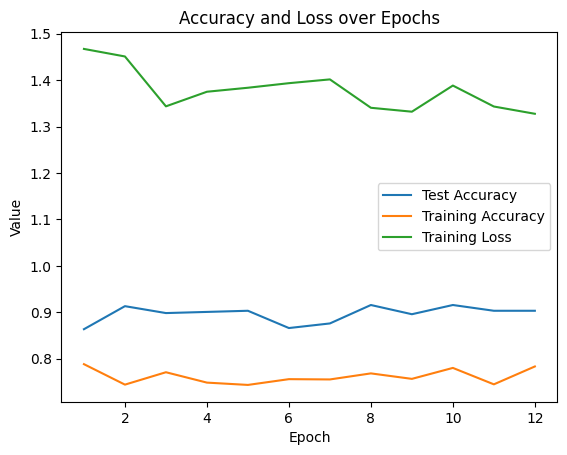

In [ ]:
plt.plot(range(1, num_epochs + 1), test_acc_list, label='Test Accuracy')
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss over Epochs')
plt.legend()
plt.show()